# Projeto 4 - Supercomputação
### Lucas Chen Alba

## Descrição do problema

Este projeto consiste em realizar simulações do conhecido problema do ciaxeiro-viajante (https://en.wikipedia.org/wiki/Travelling_salesman_problem) e analisar o ganho de velocidade utilizando técnicas de MPI.

O MPI (Message Passing Interface) permite a troca de mensagens entre "workers", sejam eles "threads" de um mesmo computador, ou computadores remotos, possibilitando a divisão inteligente de trabalho.

A primeira técnica para encontrar o caminho ótimo é a enumeração exaustiva, que consiste em testar todos os caminhos possíveis e elegir o melhor dentre eles.

A segunda técnica utilizada é a busca local, a qual não encontra o caminho ótimo para o caixeiro, mas o sub-ótimo.


## Medições de tempo

Para as medições do tempo gasto nas simulações foi utilizada a biblioteca _chrono_. Cada simulação envia o seu tempo de execução para um arquivo _.json_.

Foram testadas as entradas de tamanho 10, 11 e 12. Medindo o tempo apenas uma vez para cada simulação, sendo elas a simulação paralela (OpenMP) em CPU, e as duas utilizando MPI.

A simulação utiliza-se das seguites _flags_ de compilação MPI:


__-lboost_mpi -lboost_serialization__

## Organização geral do código

### Enumeração exaustiva
A enumeração exaustiva consiste em testar todos os possíveis caminhos que o caixeiro viajante pode realizar, podendo assim garantir obter o resultado ótimo.
#### Explicação do código

__int main()__: Na "main" o nó principal (rank 0) realiza a coleta de dados do input e distribui via _broadcast_ para todos os workers disponíveis. De posse dos dados, todos os workers realizam a chamada da função _backtrack_ (explicação a seguir).

__double backtrack()__: Aqui é que ocorre a real distribuição do trabalho entre os _workers_. Esta função realiza chamadas recursivas para testar todos os possíveis caminhos. Podemos abstrair as chamadas recursivas para uma árvore de chamadas, segue um exemplo para 4 nós na rede: Em uma situação sequencial o nó 0 realiza a chamada de para as _sub-árvores_ dos nós 1, 2 e 3. A diferença nesta simulação é que cada sub-árvore será executada por um worker diferente (caso o número de workers seja maior do que o número de nós), caso contrário o número de sub-árvores é sub-dividio igualmente entre os workers. Assim que a execução desta função termina, todos os workers enviam o seu melhor caminho para o nó 0, podendo assim comparar todos resultados e retornar o melhor.



### Busca Local
A busca local consiste em calcular o caminho sub-ótimo para múltiplos caminhos aleatórios
#### Explicação do código
__int main()__: Na "main", o nó principal (rank 0) realiza a coleta de dados do input e distribui via _broadcast_ para todos os workers disponíveis. De posse dos dados, todos os workers realizam um número fixo de de iterações, onde cada iteração consiste em randomizar a ordem dos pontos recebidos e realizar a chamada da função _local_search_.

__void local_search()__: Nesta função, cada worker realizara trocas na ordem dos pontos dados, com o objetivo de alcançar o melhor caminho local, basicamente ele retira intersecções entre os nós.
Quando todas as iterações são feitas, temos um caminho sub-ótimo para cada worker, podendo assim passar adiante o valor para o nó 0, o qual realizará a comparação dos diferentes caminhos e retornará o melhor deles.


In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import subprocess
import math

In [2]:
# Build simulations

subprocess.run(['cmake', '..'], cwd='../build')
subprocess.run(['make'], cwd='../build')

CompletedProcess(args=['make'], returncode=0)

In [19]:
times = []
# Opening files with times
with open('ex_enum10.json') as ex_enum:
    with open('loc_sea10.json') as loc_sea:
        with open('cpu_par10.json') as par:
            ex_en = json.load(ex_enum)
            loc_s = json.load(loc_sea)
            c_par = json.load(par)
            times.append(
                [math.log(ex_en['mean']*100),
                 math.log(loc_s['mean']*100),
                 math.log(c_par['mean']*100)])

with open('ex_enum11.json') as ex_enum:
    with open('loc_sea11.json') as loc_sea:
        with open('cpu_par11.json') as par:
            ex_en = json.load(ex_enum)
            loc_s = json.load(loc_sea)
            c_par = json.load(par)
            times.append(
                [math.log(ex_en['mean']*100),
                 math.log(loc_s['mean']*100),
                 math.log(c_par['mean']*100)])

with open('ex_enum12.json') as ex_enum:
    with open('loc_sea12.json') as loc_sea:
        with open('cpu_par12.json') as par:
            ex_en = json.load(ex_enum)
            loc_s = json.load(loc_sea)
            c_par = json.load(par)
            times.append(
                [math.log(ex_en['mean']*100),
                 math.log(loc_s['mean']*100),
                 math.log(c_par['mean']*100)])

print(times)

[[4.952751911647706, 4.381203796235167, 4.748213694651813], [7.140025059294605, 4.455266640968482, 7.121656248929415], [9.863264337045257, 4.574874882596147, 9.601645701926314]]


Text(0.5, 1.0, 'Time to execute')

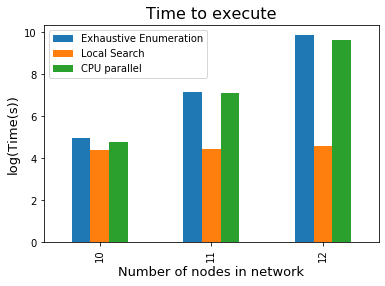

In [20]:
# Mean times
groups = times
group_labels = ['10', '11', '12']

# Convert data to pandas DataFrame.
df = pd.DataFrame(groups, index=group_labels).T

# Plot.
pd.concat(
    [df.loc[0].rename('Exhaustive Enumeration'),
     df.loc[1].rename('Local Search'),
     df.loc[2].rename('CPU parallel')],
    axis=1).plot.bar()
plt.xlabel('Number of nodes in network', fontsize=13)
plt.ylabel('log(Time(s))', fontsize=13)
plt.title('Time to execute', fontsize=16)

## Como executar na AWS

Para executar o mesmo código na AWS em múltiplas máquinas, supondo que elas possuam uma pasta compartilhada através do NFS e SSH sem senha entre elas, basta executar o seguinte comando:

__mpiexec --oversubscribe -n 5 -hostfile hosts ./a.out < inputs/in10__

## Resultados e análises

Percebemos uma diferença brutal nos resultados, mesmo aplicando o logarítimo em ambas as medições, o código da busca local é muito mais rápido do que o código exaustivo. Isso se dá principalmente pela natureza da busca local, a qual depende muito pouco do número de nós na rede do caixeiro, tendo tempos de execução quase constantes.

Em contraste, o código exaustivo, possui tempos que aumentam exponencialmente com o número de nós, pois para cada nó adicional, é preciso testar _n-1_ caminhos adicionais.